# Azure DocumentDB Customer 360 App Simulation

This notebook demonstrates how to build a modern, intelligent customer data platform using Azure DocumentDB.

## Objectives
- Provision DocumentDB database and collections required.
- Generate hundreds of customers with their bank and credit card transactions data.
- Use various Aggregation pipelines 
- Incorporate Graph lookups
- Power BI style dashboards for real-time insights
- Vector Embeddings + Retrieval-Augmented Generation (RAG) with Azure OpenAI

## Prerequisites
- Azure DocumentDB cluster setup.
- Python 3.9+ environment with Jupyter Notebook.
- Azure DocumentDB connection string, Open AI endpoint and key.
- Ensure proper permissions to write input files under the data folder, and create a .env file for the credentials required.
- Please refer to this link to create python environments in VS Code, [Python environments in VS Code](https://code.visualstudio.com/docs/python/environments)

In [6]:
from faker import Faker
import random
import pandas as pd
import os
from datetime import datetime
from pymongo import MongoClient
import pandas as pd
from dotenv import dotenv_values
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import quote_plus
import networkx as nx

env_name = ".env" # using config.env template, change to your own .env file name
config = dotenv_values(env_name)

connection_string = config['DOCUMENTDB_CONN_STRING']
cust_file_path = "./data/customers.csv"
bank_trans_file_path = "./data/customer_bank_transactions.csv"
cc_trans_file_path = "./data/customer_credit_card_transactions.csv"
db_name = "customer360"

## Generate Sample Customer 360 Data with Bank and Credit Card Transactions

In [7]:
def format_elapsed_time(elapsed_seconds):
    hours, remainder = divmod(elapsed_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{int(hours):02}:{int(minutes):02}:{seconds:05.2f}"

start_time = datetime.now()

fake = Faker()
Faker.seed(0)
random.seed(0)

# Generate synthetic customer profiles
def generate_customers(num_customers):
    customers = []
    for i in range(num_customers):
        customer_id = f"C{1000 + i}"
        customers.append({
            "customer_id": customer_id,
            "name": fake.name(),
            "email": fake.email(),
            "phone": fake.phone_number(),
            "address": fake.address().replace("\n", ", "),
            "dob": fake.date_of_birth(minimum_age=18, maximum_age=80).strftime("%Y-%m-%d"),
            "account_open_date": fake.date_between(start_date='-10y', end_date='today').strftime("%Y-%m-%d")
        })
    return customers

# Generate synthetic bank transactions
def generate_bank_transactions(customers, num_transactions):
    transactions = []
    transaction_types = ["deposit", "withdrawal", "transfer"]
    for i in range(num_transactions):
        customer = random.choice(customers)
        transactions.append({
            "transaction_id": f"B{10000 + i}",
            "customer_id": customer["customer_id"],
            "date": fake.date_between(start_date='-2y', end_date='today').strftime("%Y-%m-%d"),
            "type": random.choice(transaction_types),
            "amount": round(random.uniform(50, 5000), 2),
            "description": fake.sentence()
        })
    return transactions

# Generate synthetic credit card transactions
def generate_credit_card_transactions(customers, num_transactions):
    transactions = []
    categories = ["groceries", "travel", "electronics", "restaurants", "clothing", "utilities"]
    for i in range(num_transactions):
        customer = random.choice(customers)
        transactions.append({
            "transaction_id": f"CC{20000 + i}",
            "customer_id": customer["customer_id"],
            "date": fake.date_between(start_date='-2y', end_date='today').strftime("%Y-%m-%d"),
            "merchant": fake.company(),
            "category": random.choice(categories),
            "amount": round(random.uniform(10, 2000), 2),
            "description": fake.sentence()
        })
    return transactions

# Generate and save datasets
num_customers = 100
num_bank_transactions = 500
num_credit_card_transactions = 500

customers = generate_customers(num_customers)
bank_transactions = generate_bank_transactions(customers, num_bank_transactions)
credit_card_transactions = generate_credit_card_transactions(customers, num_credit_card_transactions)

# Ensure the directory exists if not create it
os.makedirs(os.path.dirname(cust_file_path), exist_ok=True)

os.makedirs(os.path.dirname(bank_trans_file_path), exist_ok=True)

os.makedirs(os.path.dirname(cc_trans_file_path), exist_ok=True)

pd.DataFrame(customers).to_csv(cust_file_path, index=False)
pd.DataFrame(bank_transactions).to_csv(bank_trans_file_path, index=False)
pd.DataFrame(credit_card_transactions).to_csv(cc_trans_file_path, index=False)

print("Synthetic datasets saved as CSV files.")

end_time = datetime.now()
print(f"Generated customer transactions and saved to {cust_file_path, bank_trans_file_path, cc_trans_file_path}")

elapsed_time = end_time - start_time
elapsed_time_str = format_elapsed_time(elapsed_time.total_seconds())
print(f"Total time taken to generate the input file HH:MM:SS: {elapsed_time_str}")

Synthetic datasets saved as CSV files.
Generated customer transactions and saved to ('./data/customers.csv', './data/customer_bank_transactions.csv', './data/customer_credit_card_transactions.csv')
Total time taken to generate the input file HH:MM:SS: 00:00:00.12


## Ingest Data into Azure DocumentDB

In [5]:
# Replace with your Azure DocumentDB connection string
client = MongoClient(connection_string)
client.drop_database(db_name) #drop if DB exists and recreate
db = client[db_name]

# Load CSVs
customers_df = pd.read_csv(cust_file_path)
bank_tx_df = pd.read_csv(bank_trans_file_path)
cc_tx_df = pd.read_csv(cc_trans_file_path)

start_time = datetime.now()
# Insert into DocumentDB, provide the respective collection names
db.customers.insert_many(customers_df.to_dict(orient="records"))
db.customer_bank_trans.insert_many(bank_tx_df.to_dict(orient="records"))
db.customer_card_trans.insert_many(cc_tx_df.to_dict(orient="records"))

end_time = datetime.now()
elapsed_time = end_time - start_time
elapsed_time_str = format_elapsed_time(elapsed_time.total_seconds())
print(f"Total time taken to insert the input files to DocumentDB collections, HH:MM:SS: {elapsed_time_str}")

/tmp/ipykernel_9462/3750403818.py:2: UserWarning: You appear to be connected to a CosmosDB cluster. For more information regarding feature compatibility and support please visit https://www.mongodb.com/supportability/cosmosdb
  client = MongoClient(connection_string)
/home/begriff/.local/lib/python3.11/site-packages/pymongo/synchronous/mongo_client.py:1737: UserWarning: You appear to be connected to a CosmosDB cluster. For more information regarding feature compatibility and support please visit https://www.mongodb.com/supportability/cosmosdb
  self._resolve_srv()


OperationFailure: Invalid account: User details not found in the database, full error: {'ok': 0.0, 'errmsg': 'Invalid account: User details not found in the database', 'code': 18, 'codeName': 'AuthenticationFailed'}

## Build various aggregation query pipelines
### # 1. Customers with accounts older than 5 years

In [5]:
from pprint import pprint
from datetime import datetime, UTC

now = datetime.now(UTC)

# 1. Customers with accounts older than 5 years
print("\n1. Customers with accounts older than 5 years:")
result1 = db.customers.aggregate([
    {
        "$addFields": {
            "account_open_date_dt": {
                "$cond": {
                    "if": { "$eq": [{ "$type": "$account_open_date" }, "string"] },
                    "then": { "$dateFromString": { "dateString": "$account_open_date" } },
                    "else": "$account_open_date"
                }
            }
        }
    },
    {
        "$addFields": {
            "account_age": {
                "$divide": [
                    { "$subtract": [now, "$account_open_date_dt"] },
                    1000 * 60 * 60 * 24 * 365  # Convert milliseconds to years
                ]
            }
        }
    },
    {
        "$match": {
            "account_age": { "$gt": 5 }
        }
    },
    {
        "$sort": { "account_age": -1 }
    },
    {
        "$limit": 5
    }
])
pprint(list(result1))


1. Customers with accounts older than 5 years:
[{'_id': ObjectId('699686913fdefe3cfe846039'),
  'account_age': 9.997685143613648,
  'account_open_date': '2016-02-23',
  'account_open_date_dt': datetime.datetime(2016, 2, 23, 0, 0),
  'address': '8589 Stout Garden Apt. 296, Jillstad, NY 49476',
  'customer_id': 'C1083',
  'dob': '1946-06-16',
  'email': 'michaelryan@example.org',
  'name': 'Richard Wilson',
  'phone': '278.528.1256x8218'},
 {'_id': ObjectId('699686913fdefe3cfe845fee'),
  'account_age': 9.931931718956113,
  'account_open_date': '2016-03-18',
  'account_open_date_dt': datetime.datetime(2016, 3, 18, 0, 0),
  'address': '71760 Rogers Spur Apt. 296, North Lindseyborough, WA 29475',
  'customer_id': 'C1008',
  'dob': '1948-12-27',
  'email': 'parkermelody@example.net',
  'name': 'Brian Cross',
  'phone': '946-954-6118'},
 {'_id': ObjectId('699686913fdefe3cfe84603a'),
  'account_age': 9.671657746353373,
  'account_open_date': '2016-06-21',
  'account_open_date_dt': datetime.da

### 2. Credit card transactions over $300 in groceries

In [6]:
# 2. Credit card transactions over $300 in groceries
print("\n2. Credit card transactions over $300 in groceries:")
result2 = db.customer_card_trans.aggregate([
    {
        "$match": {
            "amount": { "$gt": 300 },
            "category": "groceries"
        }
    }, { "$limit": 5 }

])
pprint(list(result2))


2. Credit card transactions over $300 in groceries:
[{'_id': ObjectId('699686923fdefe3cfe84623e'),
  'amount': 393.85,
  'category': 'groceries',
  'customer_id': 'C1040',
  'date': '2025-01-28',
  'description': 'Beyond such offer much charge notice practice should.',
  'merchant': 'Smith Ltd',
  'transaction_id': 'CC20000'},
 {'_id': ObjectId('699686923fdefe3cfe84624a'),
  'amount': 833.53,
  'category': 'groceries',
  'customer_id': 'C1024',
  'date': '2025-12-26',
  'description': 'Article technology later.',
  'merchant': 'Maddox-Bolton',
  'transaction_id': 'CC20012'},
 {'_id': ObjectId('699686923fdefe3cfe84624c'),
  'amount': 1204.89,
  'category': 'groceries',
  'customer_id': 'C1049',
  'date': '2025-06-29',
  'description': 'Action why seem too laugh door.',
  'merchant': 'Duarte, Mason and Brown',
  'transaction_id': 'CC20014'},
 {'_id': ObjectId('699686923fdefe3cfe846259'),
  'amount': 1075.87,
  'category': 'groceries',
  'customer_id': 'C1010',
  'date': '2024-11-10',
  

### 3. Bank withdrawals over $200

In [7]:
# 3. Bank withdrawals over $200
print("\n3. Bank withdrawals over $200:")
result3 = db.customer_bank_trans.aggregate([
    {
        "$match": {
            "type": "withdrawal",
            "amount": { "$gt": 200 }
        }
    }, { "$limit": 5 }
])
pprint(list(result3))


3. Bank withdrawals over $200:
[{'_id': ObjectId('699686913fdefe3cfe84604a'),
  'amount': 250.4,
  'customer_id': 'C1049',
  'date': '2025-11-04',
  'description': 'Democrat wife give song computer respond.',
  'transaction_id': 'B10000',
  'type': 'withdrawal'},
 {'_id': ObjectId('699686913fdefe3cfe84604b'),
  'amount': 2054.42,
  'customer_id': 'C1065',
  'date': '2024-07-13',
  'description': 'Good her few eight.',
  'transaction_id': 'B10001',
  'type': 'withdrawal'},
 {'_id': ObjectId('699686913fdefe3cfe84604c'),
  'amount': 1822.34,
  'customer_id': 'C1038',
  'date': '2026-02-18',
  'description': 'Ten agree weight statement.',
  'transaction_id': 'B10002',
  'type': 'withdrawal'},
 {'_id': ObjectId('699686913fdefe3cfe846052'),
  'amount': 2387.11,
  'customer_id': 'C1087',
  'date': '2025-10-15',
  'description': 'Star feel chance although address politics.',
  'transaction_id': 'B10008',
  'type': 'withdrawal'},
 {'_id': ObjectId('699686913fdefe3cfe846053'),
  'amount': 2199.

### 4. Group transactions by customer and count

In [8]:
# 4. Group transactions by customer and count
print("\n4. Group transactions by customer and count:")
result4 = db.customer_bank_trans.aggregate([
    {
        "$group": {
            "_id": "$customer_id",
            "total_transactions": { "$sum": 1 },
            "total_amount": { "$sum": "$amount" }
        }
    },
    {
        "$sort": { "total_amount": -1 }
    }, { "$limit": 5 }
])
pprint(list(result4))


4. Group transactions by customer and count:
[{'_id': 'C1089', 'total_amount': 33785.5, 'total_transactions': 13},
 {'_id': 'C1010', 'total_amount': 29838.839999999997, 'total_transactions': 9},
 {'_id': 'C1032', 'total_amount': 27790.070000000003, 'total_transactions': 9},
 {'_id': 'C1077', 'total_amount': 25284.95, 'total_transactions': 11},
 {'_id': 'C1016', 'total_amount': 24754.55, 'total_transactions': 10}]


### 5. Monthly spending summary for credit cards

In [9]:
# 5. Monthly spending summary for credit cards
print("\n5. Monthly spending summary for credit cards:")
result5 = db.customer_card_trans.aggregate([
    {
        "$addFields": {
            "month": { "$month": { "$dateFromString": { "dateString": "$date" } } },
            "year": { "$year": { "$dateFromString": { "dateString": "$date" } } }
        }
    },
    {
        "$group": {
            "_id": { "year": "$year", "month": "$month" },
            "total_spent": { "$sum": "$amount" },
            "transaction_count": { "$sum": 1 }
        }
    },
    {
        "$sort": { "_id.year": -1, "_id.month": -1 }
    }
    , 
    { "$limit": 5 }
])
pprint(list(result5))


5. Monthly spending summary for credit cards:
[{'_id': {'month': 2, 'year': 2026},
  'total_spent': 3755.5600000000004,
  'transaction_count': 6},
 {'_id': {'month': 1, 'year': 2026},
  'total_spent': 18251.01,
  'transaction_count': 19},
 {'_id': {'month': 12, 'year': 2025},
  'total_spent': 18530.489999999998,
  'transaction_count': 19},
 {'_id': {'month': 11, 'year': 2025},
  'total_spent': 15869.660000000002,
  'transaction_count': 14},
 {'_id': {'month': 10, 'year': 2025},
  'total_spent': 23159.370000000003,
  'transaction_count': 22}]


### 6. Join customers with their transactions using $lookup

In [10]:
# 6. Join customers with their transactions using $lookup
print("\n6. Join customers with their transactions using $lookup:")
result6 = db.customers.aggregate([
    {
        "$lookup": {
            "from": "bank_transactions",
            "localField": "customer_id",
            "foreignField": "customer_id",
            "as": "bank_txns"
        }
    },
    {
        "$lookup": {
            "from": "credit_card_transactions",
            "localField": "customer_id",
            "foreignField": "customer_id",
            "as": "credit_txns"
        }
    }
    , { "$limit": 5 }
])
pprint(list(result6))


6. Join customers with their transactions using $lookup:
[{'_id': ObjectId('699686913fdefe3cfe845fe6'),
  'account_open_date': '2024-03-08',
  'address': '578 Michael Island, New Thomas, VI 68835',
  'bank_txns': [],
  'credit_txns': [],
  'customer_id': 'C1000',
  'dob': '1961-07-18',
  'email': 'tammy76@example.com',
  'name': 'Norma Fisher',
  'phone': '459.638.2421x9489'},
 {'_id': ObjectId('699686913fdefe3cfe845fe7'),
  'account_open_date': '2017-12-21',
  'address': '714 Mann Plaza Suite 839, Seanfurt, MD 75952',
  'bank_txns': [],
  'credit_txns': [],
  'customer_id': 'C1001',
  'dob': '1960-05-21',
  'email': 'ypage@example.net',
  'name': 'Alexis Cortez',
  'phone': '+1-909-375-3513x9332'},
 {'_id': ObjectId('699686913fdefe3cfe845fe8'),
  'account_open_date': '2017-08-06',
  'address': '59179 Bruce Gardens Apt. 413, Lauramouth, NE 08652',
  'bank_txns': [],
  'credit_txns': [],
  'customer_id': 'C1002',
  'dob': '1951-06-22',
  'email': 'thomas12@example.org',
  'name': 'Aman

## Use $graphLookup feature traversal for Credit Card and Bank Transactions

In [11]:
# Define the sample customer_id
sample_customer_id = "C1001"  # Replace with a valid customer_id from your dataset

# Graph lookup pipeline to retrieve both credit card and bank transactions
pipeline = [
    {
        "$match": {"customer_id": sample_customer_id}
    },
    {
        "$graphLookup": {
            "from": "customer_card_trans",
            "startWith": "$customer_id",
            "connectFromField": "customer_id",
            "connectToField": "customer_id",
            "as": "related_credit_card_transactions"
        }
    },
    {
        "$graphLookup": {
            "from": "customer_bank_trans",
            "startWith": "$customer_id",
            "connectFromField": "customer_id",
            "connectToField": "customer_id",
            "as": "related_bank_transactions"
        }
    },
    {
        "$project": {
            "customer_id": 1,
            "name": 1,
            "related_credit_card_transactions": 1,
            "related_bank_transactions": 1
        }
    }
]

# Execute the aggregation
graph_result = list(db.customers.aggregate(pipeline))

# Print results
if graph_result:
    print(f"🔍 Related credit card transactions for customer {sample_customer_id}:")
    for txn in graph_result[0]["related_credit_card_transactions"]:
        print(txn)

    print(f"\n🏦 Related bank transactions for customer {sample_customer_id}:")
    for txn in graph_result[0]["related_bank_transactions"]:
        print(txn)
else:
    print(f"❌ No customer found with ID {sample_customer_id}")

🔍 Related credit card transactions for customer C1001:
{'_id': ObjectId('699686923fdefe3cfe8462cb'), 'transaction_id': 'CC20141', 'customer_id': 'C1001', 'date': '2024-07-15', 'merchant': 'Reynolds-Payne', 'category': 'restaurants', 'amount': 716.18, 'description': 'Effort long pattern catch woman.'}
{'_id': ObjectId('699686923fdefe3cfe84632e'), 'transaction_id': 'CC20240', 'customer_id': 'C1001', 'date': '2025-03-07', 'merchant': 'Griffin Group', 'category': 'travel', 'amount': 844.49, 'description': 'Per enough enough responsibility significant.'}
{'_id': ObjectId('699686923fdefe3cfe846357'), 'transaction_id': 'CC20281', 'customer_id': 'C1001', 'date': '2025-10-25', 'merchant': 'White, Kennedy and Clark', 'category': 'electronics', 'amount': 1608.66, 'description': 'Now various keep various south certain news.'}
{'_id': ObjectId('699686923fdefe3cfe84636e'), 'transaction_id': 'CC20304', 'customer_id': 'C1001', 'date': '2024-05-02', 'merchant': 'Walters-Atkinson', 'category': 'electron

## Graph Visualization using Python libraries, similar approach can be used on other Graph Visualization tools

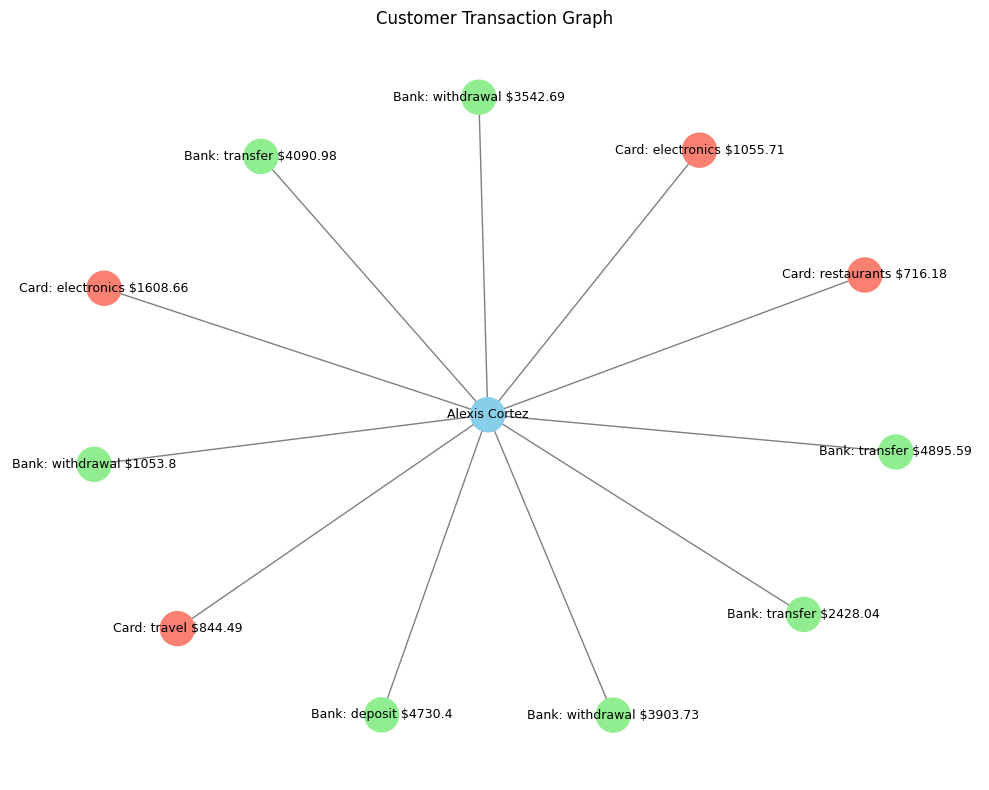

In [12]:
# Create graph
G = nx.Graph()

# print(graph_result)
customer_data = graph_result[0]

# Add customer node
customer_id = customer_data["customer_id"]
customer_name = customer_data["name"]
G.add_node(customer_id, label=customer_name, type="customer")

# Add credit card transaction nodes and edges
for tx in customer_data["related_credit_card_transactions"]:
    tx_id = tx["transaction_id"]
    tx_label = f"Card: {tx['category']} ${tx['amount']}"
    G.add_node(tx_id, label=tx_label, type="credit_card_tx")
    G.add_edge(customer_id, tx_id)

# Add bank transaction nodes and edges
for tx in customer_data["related_bank_transactions"]:
    tx_id = tx["transaction_id"]
    tx_label = f"Bank: {tx['type']} ${tx['amount']}"
    G.add_node(tx_id, label=tx_label, type="bank_tx")
    G.add_edge(customer_id, tx_id)

# Draw graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Assign colors based on node type
node_colors = []
for node, data in G.nodes(data=True):
    if data["type"] == "customer":
        node_colors.append("skyblue")
    elif data["type"] == "bank_tx":
        node_colors.append("lightgreen")
    else:
        node_colors.append("salmon")

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=600)
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw labels
labels = {node: data["label"] for node, data in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels, font_size=9)

plt.title("Customer Transaction Graph")
plt.axis("off")
plt.tight_layout()
plt.show()

## Graph Visualization of Customer Transactions
### Customers → Transactions → Merchants
### Customers → Transactions → Categories

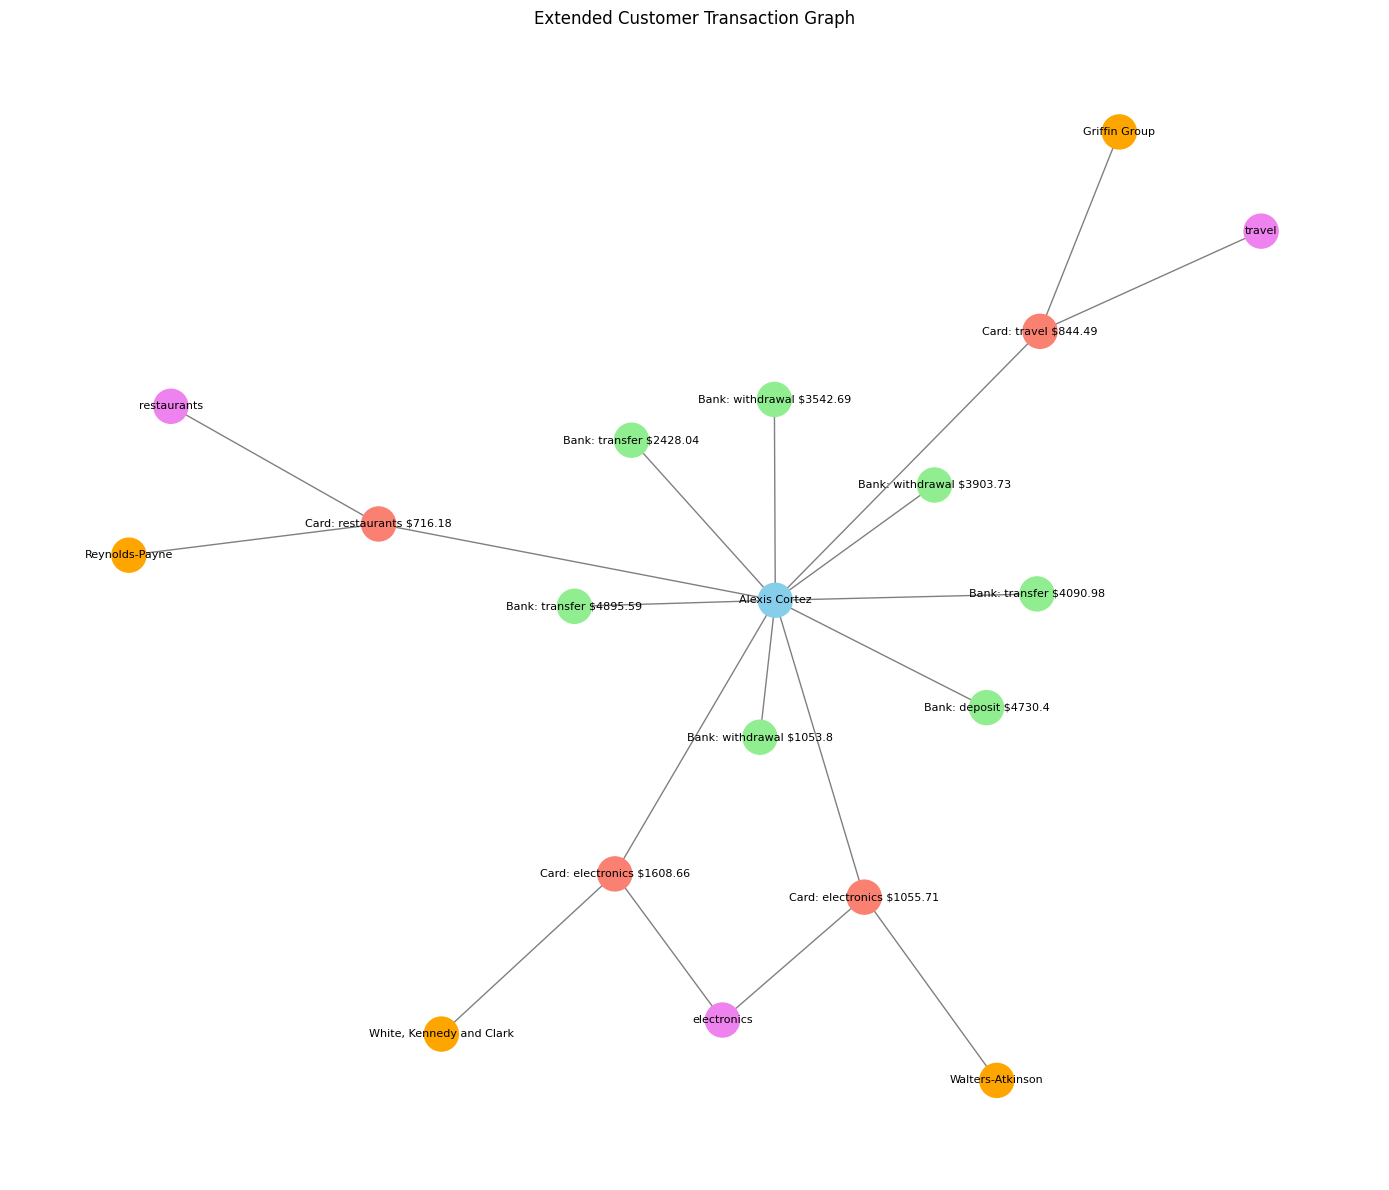

In [13]:

# Create graph
G = nx.Graph()

# print(graph_result)
customer_data = graph_result[0]

# Add customer node
customer_id = customer_data["customer_id"]
G.add_node(customer_id, label=customer_data["name"], type="customer")

# Add credit card transactions and merchant/category/offer nodes
for tx in customer_data["related_credit_card_transactions"]:
    tx_id = tx["transaction_id"]
    tx_label = f"Card: {tx['category']} ${tx['amount']}"
    merchant = tx["merchant"]
    category = tx["category"]
    # offer = customer_data["offers"].get(category, "No offer")

    # Transaction node
    G.add_node(tx_id, label=tx_label, type="credit_card_tx")
    G.add_edge(customer_id, tx_id)

    # Merchant node
    G.add_node(merchant, label=merchant, type="merchant")
    G.add_edge(tx_id, merchant)

    # Category node
    G.add_node(category, label=category, type="category")
    G.add_edge(tx_id, category)

    # Offer node
    # G.add_node(offer, label=offer, type="offer")
    # G.add_edge(category, offer)

# Add bank transactions
for tx in customer_data["related_bank_transactions"]:
    tx_id = tx["transaction_id"]
    tx_label = f"Bank: {tx['type']} ${tx['amount']}"
    G.add_node(tx_id, label=tx_label, type="bank_tx")
    G.add_edge(customer_id, tx_id)

# Draw graph
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, seed=42)

# Assign colors based on node type
node_colors = []
for node, data in G.nodes(data=True):
    if data["type"] == "customer":
        node_colors.append("skyblue")
    elif data["type"] == "bank_tx":
        node_colors.append("lightgreen")
    elif data["type"] == "credit_card_tx":
        node_colors.append("salmon")
    elif data["type"] == "merchant":
        node_colors.append("orange")
    elif data["type"] == "category":
        node_colors.append("violet")
    elif data["type"] == "offer":
        node_colors.append("gold")
    else:
        node_colors.append("gray")

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=600)
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw labels
labels = {node: data["label"] for node, data in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title("Extended Customer Transaction Graph")
plt.axis("off")
plt.tight_layout()
plt.show()

## Customer Segmentation - Power BI-style dashboards using matplotlib and seaborn.
### DocumentDB can be integrated to Power BI for generating such dashboards.

/tmp/ipykernel_32220/3206164743.py:21: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  customer_summary["total_spending"].fillna(0, inplace=True)


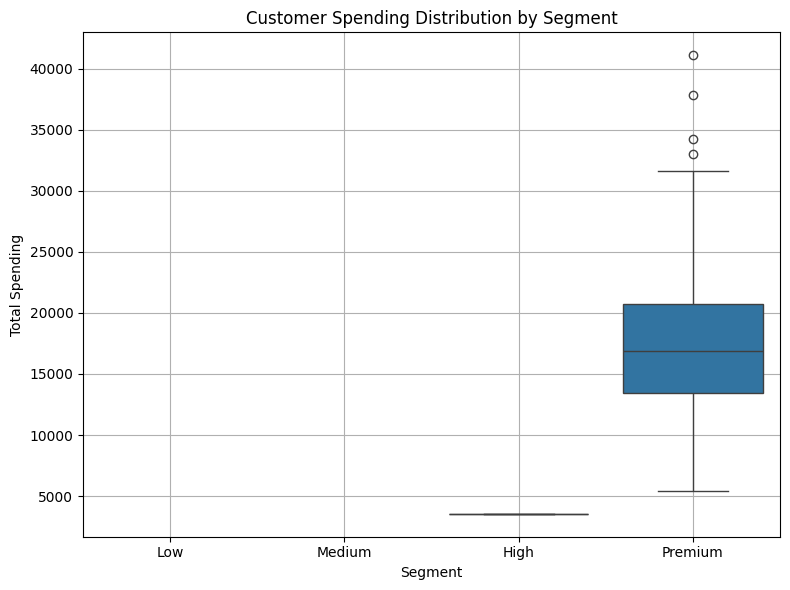

/tmp/ipykernel_32220/3206164743.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="segment", data=customer_summary, order=["Low", "Medium", "High", "Premium"], palette="Set2")


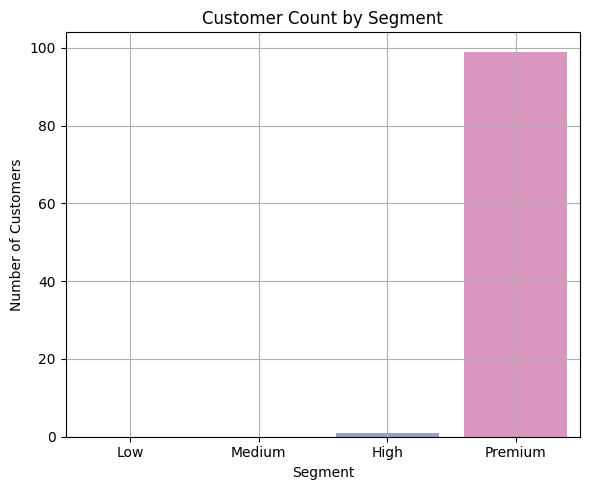

/tmp/ipykernel_32220/3206164743.py:58: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="source", y="amount", data=combined_tx_df, estimator=sum, ci=None, palette="Set1")
/tmp/ipykernel_32220/3206164743.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="source", y="amount", data=combined_tx_df, estimator=sum, ci=None, palette="Set1")


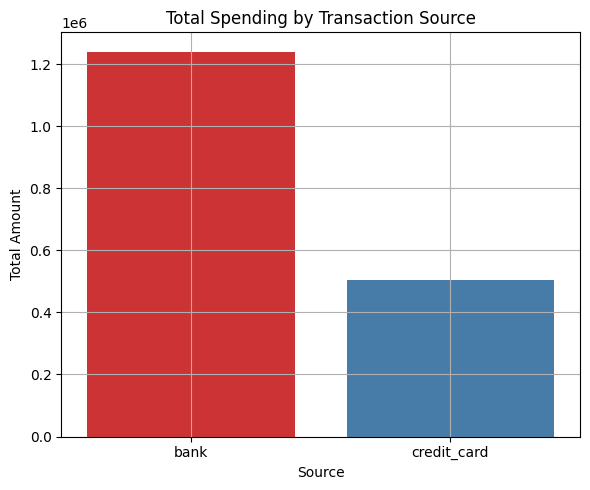

In [14]:
# Load data from MongoDB collections
customers_df = pd.DataFrame(list(db.customers.find()))
bank_tx_df = pd.DataFrame(list(db.customer_bank_trans.find()))
cc_tx_df = pd.DataFrame(list(db.customer_card_trans.find()))

# Drop MongoDB internal _id field
for df in [customers_df, bank_tx_df, cc_tx_df]:
    df.drop(columns=["_id"], inplace=True, errors="ignore")

# Combine bank and credit card transactions
bank_tx_df["source"] = "bank"
cc_tx_df["source"] = "credit_card"
combined_tx_df = pd.concat([bank_tx_df, cc_tx_df], ignore_index=True)

# Calculate total spending per customer
spending_summary = combined_tx_df.groupby("customer_id")["amount"].sum().reset_index()
spending_summary.rename(columns={"amount": "total_spending"}, inplace=True)

# Merge with customer profiles
customer_summary = pd.merge(customers_df, spending_summary, on="customer_id", how="left")
customer_summary["total_spending"].fillna(0, inplace=True)

# Segment customers based on total spending
def segment_customer(spending):
    if spending < 500:
        return "Low"
    elif spending < 2000:
        return "Medium"
    elif spending < 5000:
        return "High"
    else:
        return "Premium"

customer_summary["segment"] = customer_summary["total_spending"].apply(segment_customer)

# Plot 1: Spending distribution by segment
plt.figure(figsize=(8, 6))
sns.boxplot(x="segment", y="total_spending", data=customer_summary, order=["Low", "Medium", "High", "Premium"])
plt.title("Customer Spending Distribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Total Spending")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Count of customers by segment
plt.figure(figsize=(6, 5))
sns.countplot(x="segment", data=customer_summary, order=["Low", "Medium", "High", "Premium"], palette="Set2")
plt.title("Customer Count by Segment")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Total spending by transaction source
plt.figure(figsize=(6, 5))
sns.barplot(x="source", y="amount", data=combined_tx_df, estimator=sum, ci=None, palette="Set1")
plt.title("Total Spending by Transaction Source")
plt.xlabel("Source")
plt.ylabel("Total Amount")
plt.grid(True)
plt.tight_layout()
plt.show()

## Implement Retrieval-Augmented Generation (RAG) using IVF, HNSW, DiskANN

#### Azure DocumentDB provides robust vector search capabilities, allowing you to perform high-speed similarity searches across complex datasets. To perform vector search in Azure DocumentDB, you first need to create a vector index. While Azure DocumentDB offers multiple options, here are some general guidelines to help you get started based on the size of your dataset:

[Integrated vector store in Azure DocumentDB](https://learn.microsoft.com/en-us/azure/documentdb/vector-search?tabs=hnsw)

### Imports + config

In [16]:
import openai
from openai import AzureOpenAI
from pymongo import MongoClient
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

# Step 1: Configure Azure OpenAI
openai.api_type = config['OPENAI_API_TYPE']
openai.api_base = config['OPENAI_API_ENDPOINT']
openai.azure_endpoint = config['OPENAI_API_ENDPOINT']
openai.api_version = config['OPENAI_API_VERSION']
embedding_model = config['OPENAI_EMBEDDINGS_DEPLOYMENT']


azure_credential = DefaultAzureCredential()
token_provider = get_bearer_token_provider(azure_credential,
    "https://cognitiveservices.azure.com/.default")


azure_openai_client = AzureOpenAI(
    azure_endpoint=openai.azure_endpoint,
    azure_ad_token_provider=token_provider,
    api_version=openai.api_version,
)

# ---- Vector field settings ----
vector_field = "vectorEmbedding"
vector_dimensions = 1536
rag_coll_name = "customer_embeddings"

### Connect to DocumentDB

In [17]:
# Step 2: Connect to MongoDB
client = MongoClient(connection_string)
db = client[db_name]
db[rag_coll_name].drop()
rag_coll = db[rag_coll_name]


# quick sanity check
print("Connected. Collection:", rag_coll.full_name)


/tmp/ipykernel_32220/290620737.py:2: UserWarning: You appear to be connected to a CosmosDB cluster. For more information regarding feature compatibility and support please visit https://www.mongodb.com/supportability/cosmosdb
  client = MongoClient(connection_string)
/home/begriff/.local/lib/python3.11/site-packages/pymongo/synchronous/mongo_client.py:1737: UserWarning: You appear to be connected to a CosmosDB cluster. For more information regarding feature compatibility and support please visit https://www.mongodb.com/supportability/cosmosdb
  self._resolve_srv()


Connected. Collection: customer360.customer_embeddings


### Define Helper Functions

#### Helper Function To Drop Any Previous Vector Indexes

In [18]:

def drop_vector_indexes_on_field(collection, vector_field: str):
    idx = list(collection.list_indexes())
    to_drop = []
    for i in idx:
        # Cosmos vector indexes show up as key: { <field>: "cosmosSearch" }
        keys = i.get("key", {})
        if keys.get(vector_field) == "cosmosSearch":
            to_drop.append(i["name"])
    for name in to_drop:
        print("Dropping index:", name)
        collection.drop_index(name)
    return to_drop

dropped = drop_vector_indexes_on_field(rag_coll, vector_field)
print("Dropped:", dropped)


Dropped: []


### Types of vector indexes supported in Azure DocumentDB: IVF, HNSW, DiskANN


<style>
  table, th, td {
    font-size: 12px; /* Adjust the font size as needed */
  }
</style>

|  | IVF | HNSW | DiskANN |
| :--- | :--- | :--- | :--- |
| Description | An IVFFlat index divides vectors into lists, then searches a subset closest to the query vector. | An HNSW index creates a multilayer graph. | DiskANN is an approximate nearest neighbor search algorithm designed for efficient vector search at any scale. |
| Key trade-offs | Pros: Faster build times, lower memory use. Cons: Lower query performance (in terms of speed-recall tradeoff). | Pros: Better query performance (in terms of speed-recall tradeoff) can be created on an empty table. Cons: Slower build times, higher memory use. | Pros: Efficient at any scale, high recall, high throughput, low latency. |
| Vector count | Under 10,000 | Up to 50,000 | Up to 500,000+ |
| Recommended cluster tier | M10 or M20 | M30 and higher | M30 and higher |

#### Option 1: Helper Function To Create IVF Vector Indexes

In [19]:

def create_ivf_index(collection, vector_field: str, dimensions: int, similarity="COS", num_lists=10, index_name=None):
    if index_name is None:
        index_name = f"ivf_index_{vector_field}"

    drop_vector_indexes_on_field(collection, vector_field)

    index_command = {
        "createIndexes": collection.name,
        "indexes": [
            {
                "name": index_name,
                "key": {vector_field: "cosmosSearch"},
                "cosmosSearchOptions": {
                    "kind": "vector-ivf",
                    "dimensions": dimensions,
                    "similarity": similarity,
                    "numLists": num_lists,
                },
            }
        ],
    }
    return collection.database.command(index_command)

result = create_ivf_index(rag_coll, vector_field, vector_dimensions, similarity="COS", num_lists=10)
print(result)


{'raw': {'defaultShard': {'numIndexesBefore': 1, 'numIndexesAfter': 2, 'createdCollectionAutomatically': True, 'ok': 1}}, 'ok': 1}


#### Option 2: Helper Function To Create HNSW Vector Indexes

In [20]:

def create_hnsw_index(collection, vector_field: str, dimensions: int, similarity="COS",
                      m=16, ef_construction=64, index_name=None):
    if index_name is None:
        index_name = f"hnsw_index_{vector_field}"

    drop_vector_indexes_on_field(collection, vector_field)

    index_command = {
        "createIndexes": collection.name,
        "indexes": [
            {
                "name": index_name,
                "key": {vector_field: "cosmosSearch"},
                "cosmosSearchOptions": {
                    "kind": "vector-hnsw",
                    "dimensions": dimensions,
                    "similarity": similarity,
                    "m": m,
                    "efConstruction": ef_construction,
                },
            }
        ],
    }
    return collection.database.command(index_command)

result = create_hnsw_index(rag_coll, vector_field, vector_dimensions, similarity="COS", m=16, ef_construction=64)
print(result)


Dropping index: ivf_index_vectorEmbedding
{'raw': {'defaultShard': {'numIndexesBefore': 1, 'numIndexesAfter': 2, 'createdCollectionAutomatically': False, 'ok': 1}}, 'ok': 1}


#### Option 3: Helper Function To Create DiskANN Vector Indexes

In [21]:

def create_diskann_index(collection, vector_field: str, dimensions: int, similarity="COS",
                         max_degree=32, l_build=64, index_name=None):
    if index_name is None:
        index_name = f"diskann_index_{vector_field}"

    drop_vector_indexes_on_field(collection, vector_field)

    index_command = {
        "createIndexes": collection.name,
        "indexes": [
            {
                "name": index_name,
                "key": {vector_field: "cosmosSearch"},
                "cosmosSearchOptions": {
                    "kind": "vector-diskann",
                    "dimensions": dimensions,
                    "similarity": similarity,
                    "maxDegree": max_degree,
                    "lBuild": l_build,
                },
            }
        ],
    }
    return collection.database.command(index_command)

result = create_diskann_index(rag_coll, vector_field, vector_dimensions, similarity="COS", max_degree=32, l_build=64)
print(result)


Dropping index: hnsw_index_vectorEmbedding
{'raw': {'defaultShard': {'numIndexesBefore': 1, 'numIndexesAfter': 2, 'createdCollectionAutomatically': False, 'ok': 1}}, 'ok': 1}


#### Helper Function To Perform Vector Search Query

In [23]:

def vector_search(collection, vector_field: str, query_vector, k=5, pre_filter=None):
    cosmos_search = {
        "path": vector_field,
        "vector": query_vector,
        "k": k,
    }
    if pre_filter:
        cosmos_search["filter"] = pre_filter

    pipeline = [{"$search": {"cosmosSearch": cosmos_search}}]
    return list(collection.aggregate(pipeline))

# Example query vector (replace with embedding output)
# query_vector = [0.02] * DIMENSIONS
# results = vector_search(col, VECTOR_FIELD, query_vector, k=3)

# print("Results:", len(results))
# results[:1]


#### Read data from customer collections, create embeddings and insert to RAG collection

In [24]:
# Step 3: Read data from collections
customer_profiles = list(db["customers"].find().limit(10))

# Step 4: Embed and store documents
def embed_and_store(text, metadata):
    response = azure_openai_client.embeddings.create(
        input=[text],
        model=embedding_model
    )
    embedding = response.data[0].embedding
    doc = {
        "text": text,
        vector_field: embedding,
        "metadata": metadata
    }
    db["customer_embeddings"].insert_one(doc)



# Step 5: Process each customer and their transactions
for customer in customer_profiles:
    customer_id = customer.get("customer_id")
    print("Processing customer:", customer_id)

    # Embed customer profile
    profile_text = (
        f"Customer ID: {customer.get('customer_id')}; "
        f"Name: {customer.get('name')}; "
        f"Email: {customer.get('email')}; "
        f"Phone: {customer.get('phone')}; "
        f"Address: {customer.get('address')}; "
        f"Date of Birth: {customer.get('dob')}; "
        f"Account Open Date: {customer.get('account_open_date')}"
    )
    embed_and_store(profile_text, {"type": "customer_profile", "customer_id": customer_id})

    # Embed bank transactions
    bank_transactions = list(db["customer_bank_trans"].find({"customer_id": customer_id}))
    for txn in bank_transactions:
        txn_text = (
            f"Bank Transaction ID: {txn.get('transaction_id')}; "
            f"Customer ID: {txn.get('customer_id')}; "
            f"Date: {txn.get('date')}; "
            f"Type: {txn.get('type')}; "
            f"Amount: {txn.get('amount')}; "
            f"Description: {txn.get('description')}"
        )
        embed_and_store(txn_text, {"type": "bank_transaction", "customer_id": customer_id})

    # Embed credit card transactions
    credit_card_transactions = list(db["customer_card_trans"].find({"customer_id": customer_id}))
    for cc_txn in credit_card_transactions:
        cc_text = (
            f"Credit Card Transaction ID: {cc_txn.get('transaction_id')}; "
            f"Customer ID: {cc_txn.get('customer_id')}; "
            f"Date: {cc_txn.get('date')}; "
            f"Merchant: {cc_txn.get('merchant')}; "
            f"Category: {cc_txn.get('category')}; "
            f"Amount: {cc_txn.get('amount')}; "
            f"Description: {cc_txn.get('description')}"
        )
        embed_and_store(cc_text, {"type": "credit_card_transaction", "customer_id": customer_id})

Processing customer: C1000
Processing customer: C1001
Processing customer: C1002
Processing customer: C1003
Processing customer: C1004
Processing customer: C1005
Processing customer: C1006
Processing customer: C1007
Processing customer: C1008
Processing customer: C1009


#### Perform Vector Search Queries

In [25]:
# Sample RAG queries
# sample_queries = [
#     "Which customers have frequent withdrawals?"
# ]
sample_queries = [
    "Which customers have frequent withdrawals?",
    "Find customers with high-value transactions across both bank and credit card",
    "Which customers have unusual transaction description?",
    "Find credit card transactions in the groceries category.",
    "Who are the customers with consistent spending patterns?"
]

# Run queries
for query in sample_queries:
    print(f"\nQuery: {query}")
    query_embedding = azure_openai_client.embeddings.create(
        input=[query],
        model=embedding_model
    ).data[0].embedding
    results = vector_search(rag_coll, vector_field, query_embedding)
    # print("Results:", results)
    for result in results:
        print(f"Score: {result['__cosmos_meta__']['score']:.4f} | Text: {result['text']}")



Query: Which customers have frequent withdrawals?
Score: 0.8179 | Text: Bank Transaction ID: B10208; Customer ID: C1003; Date: 2025-05-24; Type: withdrawal; Amount: 2183.88; Description: Five admit play avoid few beat.
Score: 0.8137 | Text: Bank Transaction ID: B10130; Customer ID: C1007; Date: 2025-12-13; Type: withdrawal; Amount: 88.86; Description: Character pattern next.
Score: 0.8128 | Text: Bank Transaction ID: B10288; Customer ID: C1000; Date: 2024-04-01; Type: withdrawal; Amount: 4372.08; Description: Week car thousand a rich open person explain.
Score: 0.8100 | Text: Bank Transaction ID: B10150; Customer ID: C1001; Date: 2024-09-21; Type: withdrawal; Amount: 3542.69; Description: Into nearly water.
Score: 0.8088 | Text: Bank Transaction ID: B10477; Customer ID: C1003; Date: 2025-08-21; Type: withdrawal; Amount: 2394.94; Description: Include positive join plant ever such able.

Query: Find customers with high-value transactions across both bank and credit card
Score: 0.8280 | 